In [6]:
import librosa
import os
import pandas as pd
import glob
import numpy as np
import soundfile
from sklearn.model_selection import train_test_split

In [7]:
def extract_feature(file_name,mfcc,chroma,mel,zcr,rmse):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if zcr:
            zcr=np.mean(librosa.feature.zero_crossing_rate(y=X, frame_length=2048, hop_length=512).T,axis=0)
            result=np.hstack((result, zcr))
        if rmse:
            rmse=np.mean(librosa.feature.rms(S=stft,frame_length=2048, hop_length=512, pad_mode='reflect').T,axis=0)
            result=np.hstack((result, rmse))
    return result

In [8]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust','neutral','surprised','sad','angry']

In [11]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/drive/MyDrive/RAVDEES dataset/Actor_*//*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True,mel=True, zcr=True, rmse=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size)

In [12]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)
x_train.shape,x_test.shape

((1152, 182), (288, 182))

In [13]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [14]:
y_train=np.array(y_train)
y_test=np.array(y_test)

In [15]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [16]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(1152, 182, 1)

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 173, 64)           704       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 164, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 128)           163968    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0

In [18]:
import tensorflow.keras as keras
model_history=model.fit(x_train, y_train,batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
36/36 [==============================] - 5s 110ms/step - loss: 3.2277 - accuracy: 0.1336 - val_loss: 2.5587 - val_accuracy: 0.3090
Epoch 2/100
36/36 [==============================] - 3s 97ms/step - loss: 2.6402 - accuracy: 0.1943 - val_loss: 2.3817 - val_accuracy: 0.2361
Epoch 3/100
36/36 [==============================] - 3s 97ms/step - loss: 2.3988 - accuracy: 0.1880 - val_loss: 2.1301 - val_accuracy: 0.3403
Epoch 4/100
36/36 [==============================] - 3s 97ms/step - loss: 2.2443 - accuracy: 0.2265 - val_loss: 2.0319 - val_accuracy: 0.3056
Epoch 5/100
36/36 [==============================] - 3s 97ms/step - loss: 2.1454 - accuracy: 0.2071 - val_loss: 1.9188 - val_accuracy: 0.3368
Epoch 6/100
36/36 [==============================] - 4s 98ms/step - loss: 2.0342 - accuracy: 0.2673 - val_loss: 1.8308 - val_accuracy: 0.3750
Epoch 7/100
36/36 [==============================] - 4s 99ms/step - loss: 1.9507 - accuracy: 0.2822 - val_loss: 1.8052 - val_accuracy: 0.3368
Epoch

In [19]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

9/9 [==============================] - 0s 21ms/step - loss: 1.2954 - accuracy: 0.6111
Loss of the model is -  1.2953898906707764
9/9 [==============================] - 0s 21ms/step - loss: 1.2954 - accuracy: 0.6111
Accuracy of the model is -  61.11111044883728 %


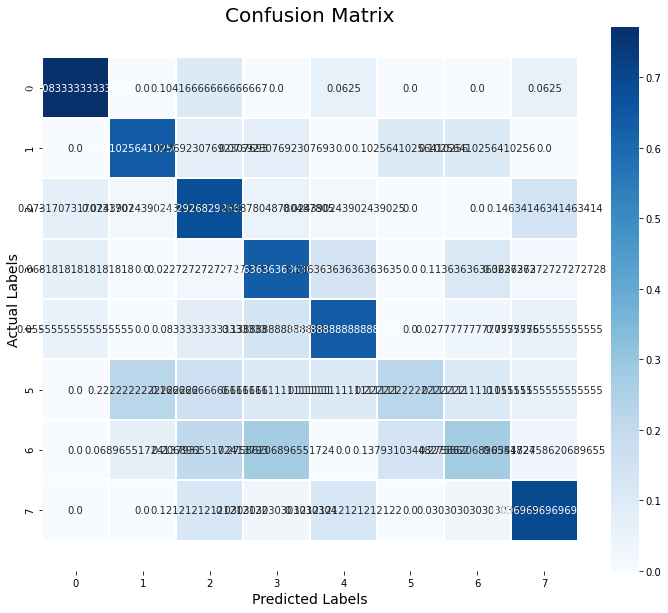

In [20]:
predictions = model.predict(x_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
cm = confusion_matrix(actual, predictions,normalize='true')
plt.figure(figsize = (12, 10))
conf_matrix= pd.DataFrame(cm,columns=None)
conf_matrix.to_csv(r'E:\confusion_matrix.csv', index = False, header=False)
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [21]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.82      0.77      0.80        48
        calm       0.78      0.64      0.70        39
     disgust       0.53      0.68      0.60        41
        fear       0.57      0.64      0.60        44
       happy       0.59      0.64      0.61        36
     neutral       0.33      0.22      0.27        18
         sad       0.38      0.28      0.32        29
    surprise       0.62      0.70      0.66        33

    accuracy                           0.61       288
   macro avg       0.58      0.57      0.57       288
weighted avg       0.61      0.61      0.61       288



In [23]:
from imblearn.metrics import specificity_score
s=specificity_score(actual,predictions,average='macro')
print(s)

0.944132170512392


In [24]:
from sklearn.metrics import roc_auc_score
y_score=model.predict(x_test)
auc=roc_auc_score(y_test, y_score, average='macro',multi_class='ovo')
print(auc)

0.8816991404882899


In [25]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
p=precision_score(actual,predictions,average='macro')
r=recall_score(actual,predictions,average='macro')
f=f1_score(actual,predictions,average='macro')
print(p,r,f)

0.5786067007617716 0.5706365396296535 0.5693702940590235


In [26]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(TPR)
print(FPR)

[0.77083333 0.64102564 0.68292683 0.63636364 0.63888889 0.22222222
 0.27586207 0.6969697 ]
[0.02812973 0.04508257 0.11170367 0.09740981 0.06508244 0.03435645
 0.05505606 0.05388037]


In [27]:
l=[]
for i in range(100):
  l.append(i+1)

In [28]:
from pandas import DataFrame
C = {'epoch no':l,
    'acc train':model_history.history['accuracy'],
    'acc val':model_history.history['val_accuracy'],
    'loss train':model_history.history['loss'],
    'loss val':model_history.history['val_loss']}
df = DataFrame(C, columns= ['epoch no','acc train','acc val','loss train','loss val'])
export_csv = df.to_csv (r'E:\result1.csv', index = None, header=True) 
print (df)

    epoch no  acc train   acc val  loss train  loss val
0          1   0.155382  0.309028    2.955658  2.558673
1          2   0.194444  0.236111    2.556458  2.381740
2          3   0.206597  0.340278    2.354466  2.130058
3          4   0.221354  0.305556    2.206949  2.031869
4          5   0.224826  0.336806    2.114163  1.918781
..       ...        ...       ...         ...       ...
95        96   0.783854  0.607639    0.861848  1.312053
96        97   0.775174  0.642361    0.858188  1.292818
97        98   0.769965  0.614583    0.882867  1.290072
98        99   0.760417  0.635417    0.892559  1.292006
99       100   0.786458  0.611111    0.873224  1.295390

[100 rows x 5 columns]


In [29]:
from pandas import DataFrame
C = {
     'train acc':[str(model_history.history['accuracy'][99])],
     'test acc':[str(model_history.history['val_accuracy'][99])],
     'precision(macro)':[str(p)],
     'recall(macro)':[str(r)],
     'f1(macro)':[str(f)],
     'specificity(macro)':[str(s)],
     'AUC(macro)':[str(auc)],
     'train time per epoch':['4 sec'],
     'test time per epoch':['4 sec'],}
df = DataFrame(C, columns= ['train acc','test acc','precision(macro)','recall(macro)','f1(macro)','specificity(macro)','AUC(macro)','train time per epoch','test time per epoch'])
export_csv = df.to_csv (r'E:\result2.csv', index = None, header=True) 
print (df)

            train acc  ... test time per epoch
0  0.7864583134651184  ...               4 sec

[1 rows x 9 columns]


In [30]:
from pandas import DataFrame
C = {
     'TPR': TPR,
     'FPR': FPR}
df = DataFrame(C, columns= ['TPR','FPR'])
export_csv = df.to_csv (r'E:\result3.csv', index = None, header=True) 
print (df)

        TPR       FPR
0  0.770833  0.028130
1  0.641026  0.045083
2  0.682927  0.111704
3  0.636364  0.097410
4  0.638889  0.065082
5  0.222222  0.034356
6  0.275862  0.055056
7  0.696970  0.053880
